In [32]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Modules imported.')

Modules imported.


# Import and parse the dataset

In [20]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

### Split pickup and dropoff columns to corresponding date and time columns

In [3]:
train['pickup_date'], train['pickup_time'] = zip(*train['pickup_datetime'].apply(lambda x: x.split(' ')))
train['dropoff_date'], train['dropoff_time'] = zip(*train['dropoff_datetime'].apply(lambda x: x.split(' ')))

In [4]:
pickup_date_year, pickup_date_month, pickup_date_day = zip(*train['pickup_date'].apply(lambda x: x.split('-')))
dropoff_date_year, dropoff_date_month, dropoff_date_day = zip(*train['dropoff_date'].apply(lambda x: x.split('-')))

In [5]:
pickup_date_month = pd.to_numeric(pickup_date_month)
pickup_date_day = pd.to_numeric(pickup_date_day)

dropoff_date_month = pd.to_numeric(dropoff_date_month)
dropoff_date_day = pd.to_numeric(dropoff_date_day)

In [6]:
pickup_days = (pickup_date_month * 30) + pickup_date_day
dropoff_days = (dropoff_date_month * 30) + dropoff_date_day

train['pickup_days'] = pickup_days
train['dropoff_days'] = dropoff_days

In [7]:
pickup_hours = pd.to_numeric(train.pickup_time.str.slice(0, 2))
dropoff_hours = pd.to_numeric(train.dropoff_time.str.slice(0, 2))

train['pickup_hours'] = pickup_hours
train['dropoff_hours'] = dropoff_hours

In [8]:
fwd_flag = pd.get_dummies(train.store_and_fwd_flag).iloc[:,1]
train['fwd_flag'] = fwd_flag

In [9]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_days,dropoff_days,pickup_hours,dropoff_hours,fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17:24:55,2016-03-14,17:32:30,104,104,17,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,00:43:35,2016-06-12,00:54:38,192,192,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11:35:24,2016-01-19,12:10:48,49,49,11,12,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19:32:31,2016-04-06,19:39:40,126,126,19,19,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13:30:55,2016-03-26,13:38:10,116,116,13,13,0


In [10]:
X = pd.DataFrame(data=train, columns=['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_days', 'dropoff_days', 'pickup_hours', 'dropoff_hours', 'fwd_flag'])
y = pd.DataFrame(data=train, columns=['trip_duration'])

In [11]:
X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_days,dropoff_days,pickup_hours,dropoff_hours,fwd_flag
0,2,1,-73.982155,40.767937,-73.964630,40.765602,104,104,17,17,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,192,192,0,0,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,49,49,11,12,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,126,126,19,19,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,116,116,13,13,0


### Visualizations

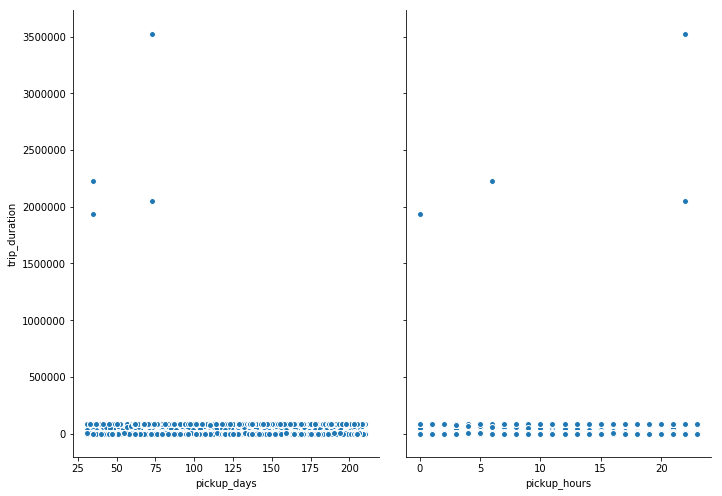

In [18]:
sns.pairplot(train, x_vars=['pickup_days', 'pickup_hours'], y_vars='trip_duration', size=7, aspect=0.7, kind='reg')

# Splitting the dataset into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [13]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_days,dropoff_days,pickup_hours,dropoff_hours,fwd_flag
879655,1,1,-73.955551,40.773346,-73.973640,40.763500,38,39,23,0,0
646838,2,1,-73.962181,40.763599,-73.980377,40.764919,95,95,9,10,0
1138713,1,1,-73.977486,40.751842,-74.011688,40.718925,129,129,16,16,0
864716,1,1,-73.970001,40.762363,-73.963264,40.774666,36,36,11,11,0
434927,1,1,-73.950348,40.771561,-73.968178,40.762409,206,206,9,9,0


In [18]:
y_train.head()

,trip_duration
879655,561
646838,486
1138713,1049
864716,425
434927,408


# Feature scaling

### Standardization

In [13]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [14]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Linear Regression

In [15]:
lr = LinearRegression(normalize=True)

In [16]:
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [26]:
fit = lr.fit(X_train, y_train)

In [30]:
pred = lr.predict(X_train)

In [33]:
print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, pred))

Coefficients: 
 [[  2.27096115e+01  -3.49325997e-01   3.03299902e+02  -5.00159147e+02
   -5.24610851e+01  -2.43889143e+02  -7.71335584e+04   7.71336739e+04
   -3.18895882e+03   3.18968569e+03   8.73957821e+00]]
Mean squared error: 2908550.37
Variance score: 0.90
